In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections.abc import Callable

import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm
from transformer_lens import HookedTransformer
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

from teren.config import ExperimentConfig, Reference
from teren.perturbations import (
    NaiveRandomPerturbation,
    RandomPerturbation,
    RandomActivationPerturbation,
    SAEDecoderDirectionPerturbation,
    run_perturbation
)
from teren.utils import (
    generate_prompt,
    load_pretokenized_dataset,
    set_seed,
    get_device_str,
    set_seed
)

In [3]:
cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=42,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0.0, np.pi),
    n_steps=361,
    mean_batch_size=700,
)

In [4]:
set_seed(cfg.seed)

In [5]:
dataset = load_pretokenized_dataset(
    path="apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split="train"
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.dataloader_batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/75 [00:00<?, ?it/s]

In [6]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [7]:
base_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
base_ref = Reference(
    model,
    base_prompt,
    cfg.perturbation_layer,
    cfg.read_layer,
    cfg.perturbation_pos,
    cfg.n_ctx,
)

In [8]:
print(base_prompt)

tensor([[ 338, 5059,  262, 6672,  287, 2669,   13, 9570, 5865, 3205]])


In [9]:
import random

rng = random.Random(cfg.seed)

In [10]:
rng.randint(0,100)

81

In [11]:
# Some experiment specific utils for converting a cov matrix
# to positive definite (we suspect it's because of smaller 
# batch size) needed for MultivariateNormal
def is_positive_definite(A):
    try:
        torch.linalg.cholesky(A)
        return True
    except RuntimeError:
        return False

def nearest_positive_definite(A):
    B = (A + A.T) / 2
    _, s, V = torch.svd(B)
    H = V.mm(torch.diag(s).mm(V.T))
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    if is_positive_definite(A3):
        return A3
    spacing = np.geomspace(torch.finfo(A.dtype).eps, 1, 10)
    for i in range(len(spacing)):
        mineig = torch.min(torch.real(torch.linalg.eigvals(A3)))
        A3 += torch.eye(A.shape[0]) * (-mineig * (1 + spacing[i]))
        if is_positive_definite(A3):
            return A3
    return A3



In [12]:
batch_of_prompts = generate_prompt(dataset, n_ctx=cfg.n_ctx, batch=cfg.mean_batch_size)
batch_act_cache = model.run_with_cache(batch_of_prompts)[1].to("cpu")
data = batch_act_cache[cfg.perturbation_layer][:, cfg.perturbation_pos, :].squeeze(1)
print(data.shape)
data_mean = data.mean(dim=0, keepdim=True)
data_cov = (
    torch.einsum("i j, i k -> j k", data - data_mean, data - data_mean) / data.shape[0]
)


torch.Size([700, 768])


In [13]:
# substitute covariance matrix with nearest that is positive definite
if not is_positive_definite(data_cov):
    data_cov = nearest_positive_definite(data_cov)

In [14]:
saes, sparsities = get_gpt2_res_jb_saes(cfg.perturbation_layer)
sae = saes[cfg.perturbation_layer].cpu()
sparsity = sparsities[cfg.perturbation_layer].cpu()

100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


In [15]:
print(sparsity.max())

tensor(-0.8965)


In [16]:
unrelated_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
unrelated_ref = Reference(
    model,
    unrelated_prompt,
    cfg.perturbation_layer,
    cfg.read_layer,
    cfg.perturbation_pos,
    cfg.n_ctx,
)

In [77]:
from teren.perturbations import SAEDecoderDirectionPerturbation
# Perturbations
naive_random_perturbation = NaiveRandomPerturbation()
random_perturbation = RandomPerturbation(data_mean, data_cov)
random_activation_perturbation = RandomActivationPerturbation(base_ref, dataset)
saedir_perturbation = SAEDecoderDirectionPerturbation(base_ref, unrelated_ref, sae, negate=-1, thresh=0.1)

perturbations = {
    "naive random direction": naive_random_perturbation,
    "random direction": random_perturbation,
    "direction to random other activation": random_activation_perturbation,
    "direction of negative active SAE decoder feature": saedir_perturbation
}

Using active features: tensor([ 4955,  6131,  8379, 11640, 21958, 24149])


In [18]:
results = defaultdict(list)

for _ in tqdm(range(10)):
    for name, perturbation in perturbations.items():
        kl_div = run_perturbation(cfg, base_ref, perturbation)
        results[name].append(kl_div)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:00<00:00,  6.01s/it]


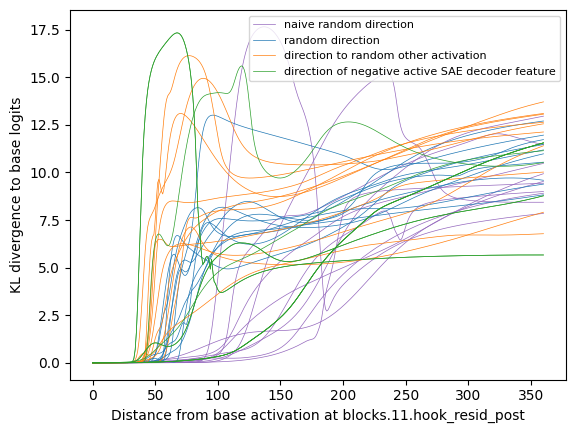

In [19]:
colors = {
    "random direction": "tab:blue",
    "naive random direction": "tab:purple",
    "direction to random other activation": "tab:orange",
    "direction of negative active SAE decoder feature": "tab:green"
}

for perturb_name in results.keys():
    for i, data in enumerate(results[perturb_name]):
        if i == 0:
            # Only label the first line for each perturb_name
            plt.plot(data, color=colors[perturb_name], label=perturb_name, linewidth=0.5)
        else:
            # Don't label subsequent lines to avoid duplicate legend entries
            plt.plot(data, color=colors[perturb_name], linewidth=0.5)

plt.legend(fontsize=8)
plt.ylabel("KL divergence to base logits")
plt.xlabel(f"Distance from base activation at {cfg.read_layer}")
plt.show()

In [16]:
import operator
from teren.perturbations import SAEFeaturePerturbation, TestPerturbation

In [17]:
# Examining SAE features
def get_results_for_prompt(exp_ref, cfg, sae, n_control, thresh, normalize=False):

    feature_acts = sae.encode(exp_ref.cache[sae.cfg.hook_name])[0, -1, :]
    active_features = {feature_idx: feature_acts[feature_idx] for feature_idx in range(feature_acts.shape[0]) if feature_acts[feature_idx] / feature_acts.max() > thresh}

    sorted_features = sorted(active_features.items(), key=operator.itemgetter(1))

    print(f"Using {len(sorted_features)} active features: {active_features}")

    results = defaultdict(defaultdict)
    control = defaultdict(list)

    for i in tqdm(range(n_control)):
        random_activation_perturbation = RandomActivationPerturbation(exp_ref, dataset)
        control_kl_div = run_perturbation(cfg, exp_ref, random_activation_perturbation)
        control[i].append(control_kl_div)

    for i in tqdm(range(len(sorted_features))):  
        saefeat_perturbation = TestPerturbation(exp_ref, sorted_features[i], sae, negate=-1)
        kl_div = run_perturbation(cfg, exp_ref, saefeat_perturbation)
        results[sorted_features[i][0]]['kl_div'] = kl_div

    #print(results.keys())
    #print(control.keys())

    assert [i[0] for i in sorted_features] == list(results.keys())

    feature_activation = torch.Tensor([feature[1] for feature in sorted_features])
    #print(feature_activation)

    recon_feature_dir = sae.W_dec[[feature[0] for feature in sorted_features]]
    feature_dot_act = torch.einsum("... k, ... k -> ...", recon_feature_dir, exp_ref.act)
    #print(feature_act_dot)

    feature_sparsity = sparsity[list(results.keys())]
    #print(feature_sparsity)

    feature_dot_feature = []
    for feature in sorted_features:
        feature_dot_all = torch.einsum("...k, ... j k -> ... j", sae.W_dec[feature[0]], sae.W_dec[[feature_idx for feature_idx in range(sae.W_dec.shape[0]) if feature_idx != feature[0]]])
        feature_dot_feature.append(feature_dot_all.min(dim=-1)[0])
    feature_dot_feature = torch.Tensor(feature_dot_feature)
    #print(feature_other)

    if normalize:
        for i, feature in enumerate(sorted_features):
            feature_activation[i] /= (feature_activation.max(dim=-1)[0])
            feature_dot_act[0][i] /= (feature_dot_act[0].max(dim=-1)[0])
            feature_sparsity[i] /= (feature_sparsity.abs().max(dim=-1)[0])
            feature_dot_feature[i] /= (-1 * feature_dot_feature.min(dim=-1)[0])

    for i, feature in enumerate(sorted_features):
        results[feature[0]]['Feature Activation'] = feature_activation[i]
        results[feature[0]]['Feature Dot Act'] = feature_dot_act[0][i]
        results[feature[0]]['Feature Sparsity'] = feature_sparsity[i]
        results[feature[0]]['Feature Dot Feature'] = feature_dot_feature[i]


    properties = {"Feature Activation": [feature_activation.min(dim=-1)[0].item(), feature_activation.max(dim=-1)[0].item()], 
                  "Feature Dot Act": [feature_dot_act.squeeze(0).min(dim=-1)[0].item(), feature_dot_act.squeeze(0).max(dim=-1)[0].item()], 
                  "Feature Sparsity": [feature_sparsity.min(dim=-1)[0].item(), feature_sparsity.max(dim=-1)[0].item()], 
                  "Feature Dot Feature": [feature_dot_feature.min(dim=-1)[0].item(), feature_dot_feature.max(dim=-1)[0].item()]}

    return results, control, properties


In [31]:
def plot_all_results(fig, ax, results, control, properties):
    colors = plt.cm.viridis(np.linspace(0,1,len(results.keys())))

    for i, color_property in enumerate(properties.keys()):
        for control_kl_div in control.values():
            ax[i][0].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")
            #ax[2].plot(control_data[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")

        plot_order = sorted(results.items(), key = lambda item: item[1][color_property])

        for j, (feature_idx, data) in enumerate(plot_order):
            kl_div = data['kl_div']
            ax[i][0].plot(kl_div, color=colors[j], linewidth=0.5)
            ax[i][1].plot(kl_div, color=colors[j], linewidth=0.5)
            ax[i][2].plot(np.log10(kl_div), color=colors[j], linewidth=0.5)

        #ax.legend(fontsize=8)
        ax[i][0].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
        ax[i][0].set_ylabel("KL divergence to base logits")
        ax[i][0].set_xlim(0,361)
        #ax[i][0].set_ylim(-0.1, 20)

        ax[i][1].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
        ax[i][1].set_ylabel("KL divergence to base logits")
        ax[i][1].set_xlim(0,361)
        #ax[i][1].set_ylim(-0.1, 20)

        ax[i][2].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
        ax[i][2].set_ylabel("KL divergence to base logits")
        ax[i][2].set_xlim(0,75)
        #ax[i][2].set_ylim(-0.01,2)

        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=properties[color_property][0], vmax=properties[color_property][1]))
        cbar = fig.colorbar(sm, ax=ax[i][2])
        cbar.set_label(color_property)
    

In [23]:
for i in tqdm(range(1)):
    exp_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
    exp_ref = Reference(
        model,
        base_prompt,
        cfg.perturbation_layer,
        cfg.read_layer,
        cfg.perturbation_pos,
        cfg.n_ctx,
    )
    n_control = 5
    results, controls, properties = get_results_for_prompt(exp_ref, cfg, sae, n_control=n_control, thresh = 0.1, normalize=False)

    if i == 0:
        all_results = results
        all_properties = properties                                     
        all_controls = controls
    else:
        for f_idx, result in results.items():
            all_results[f_idx] = result 
        
        for control_idx, control in controls.items():
            all_controls[n_control*i+control_idx] = control

        for property in properties.keys():
            all_properties[property][0] = min(properties[property][0], all_properties[property][0])
            all_properties[property][1] = max(properties[property][1], all_properties[property][1])
    print(all_properties)

  0%|          | 0/1 [00:00<?, ?it/s]

Using 6 active features: {4955: tensor(4.4000), 6131: tensor(4.8369), 8379: tensor(24.3063), 11640: tensor(12.4796), 21958: tensor(3.8892), 24149: tensor(3.5142)}


100%|██████████| 1/1 [00:24<00:00, 24.88s/it]

{'Feature Activation': [3.514174461364746, 24.306272506713867], 'Feature Dot Act': [14.156661987304688, 27.74146270751953], 'Feature Sparsity': [-3.7213802337646484, -0.949967622756958], 'Feature Dot Feature': [-0.7467800378799438, -0.139156311750412]}


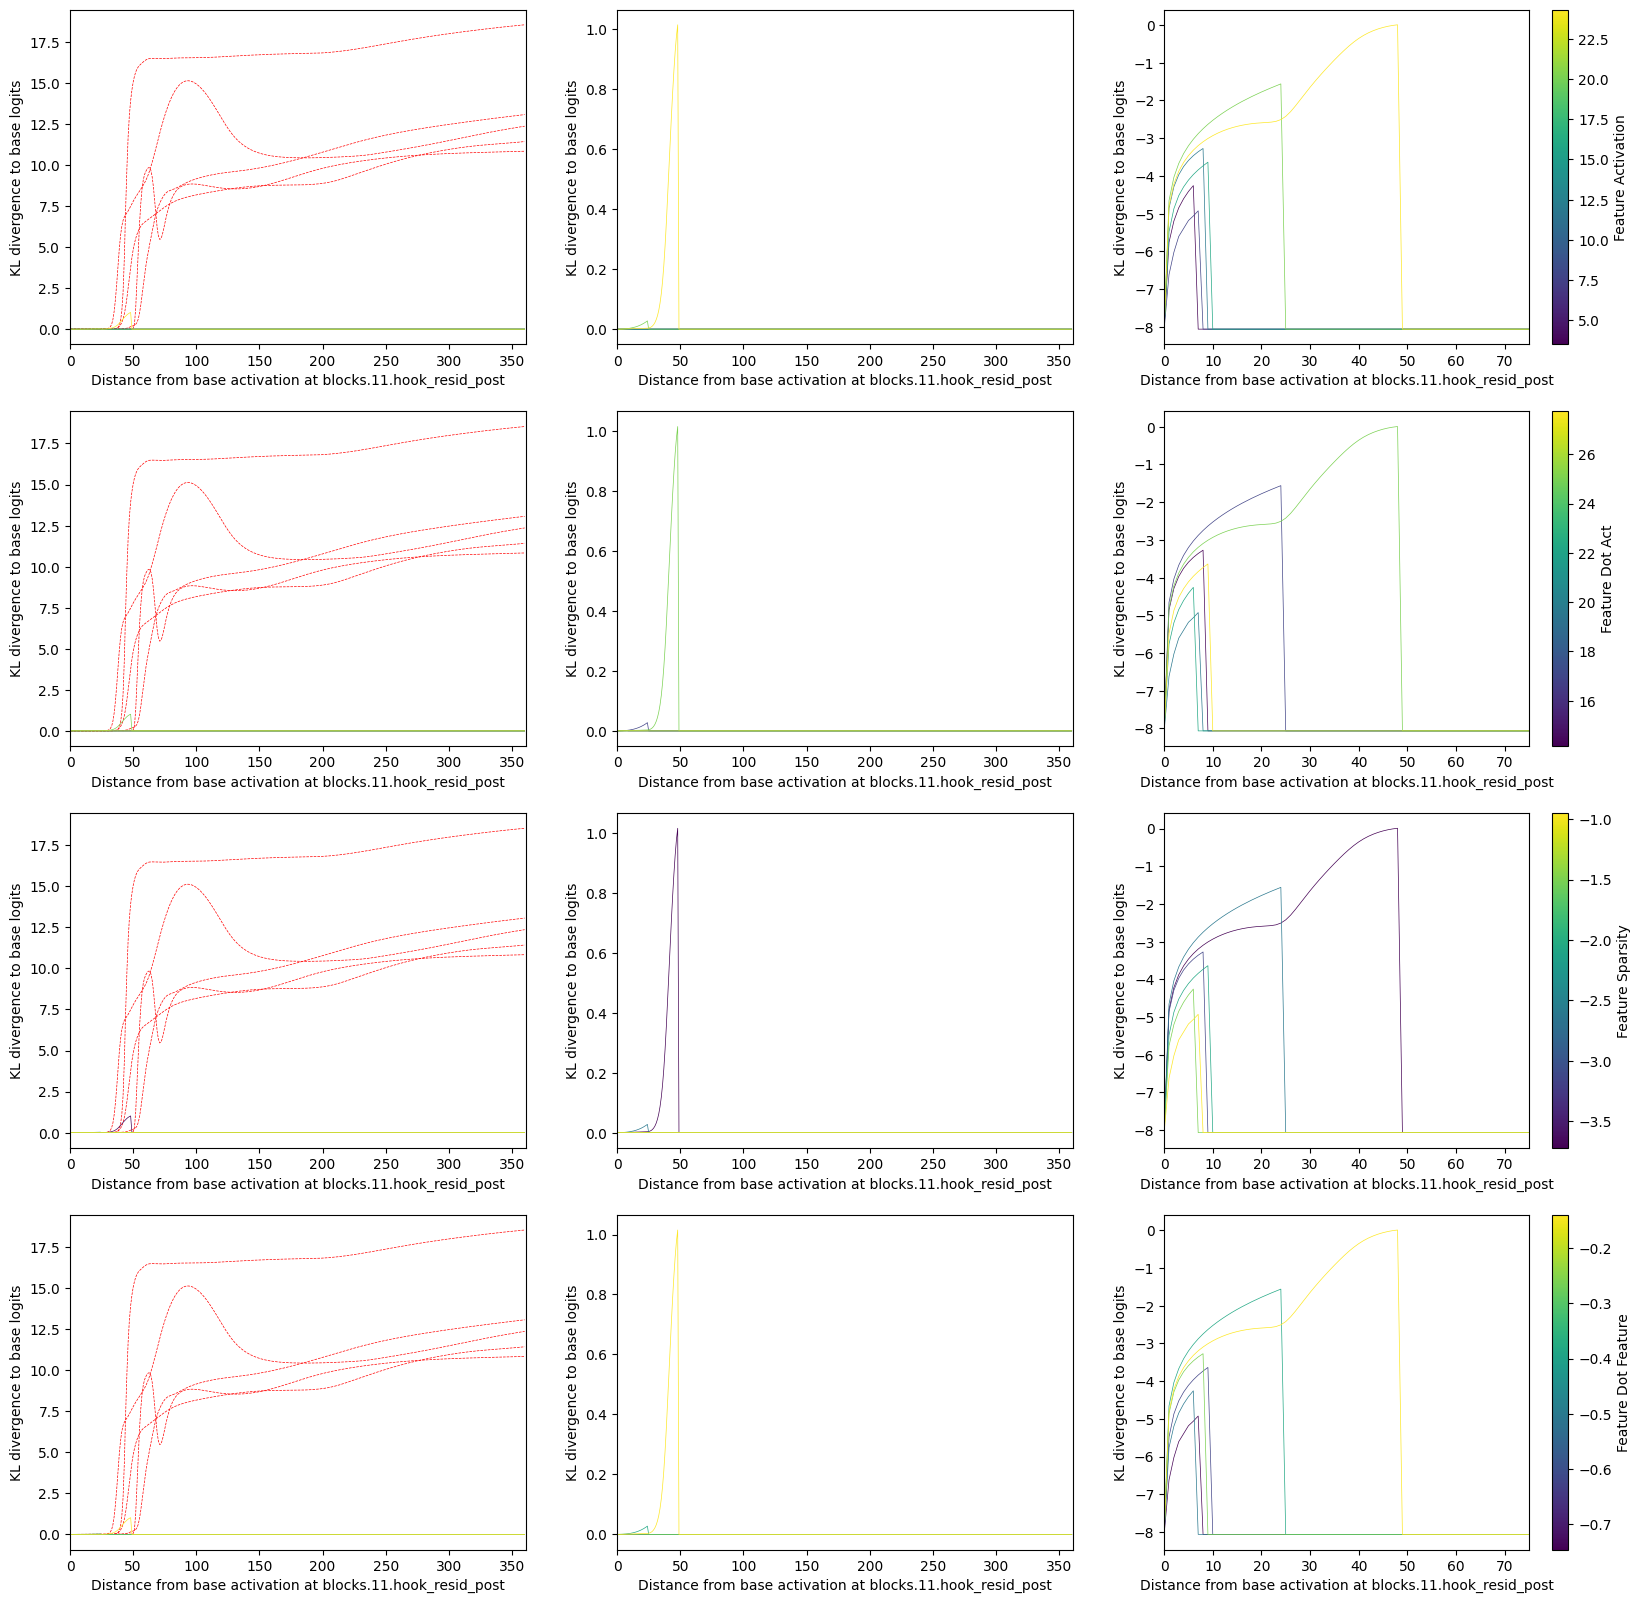

In [32]:
fig, ax = plt.subplots(len(properties.keys()), 3, figsize=(20,5*len(properties.keys())))

plot_all_results(fig, ax, all_results, all_controls, all_properties)
fig.show()

In [21]:
feature_count = {f_idx: [] for f_idx in range(sae.W_dec.shape[0])}
chosen_features = {}
for i in tqdm(range(50)):
    prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
    ref = Reference(
                model,
                prompt,
                cfg.perturbation_layer,
                cfg.read_layer,
                cfg.perturbation_pos,
                cfg.n_ctx,
            )

    thresh = 0.0
    f_acts = sae.encode(ref.cache[sae.cfg.hook_name])[0, -1, :]
    active_features = {f_idx: f_acts[f_idx] for f_idx in range(f_acts.shape[0]) if f_acts[f_idx] > thresh}
    for f_idx, f_act in active_features.items():
        if f_idx not in chosen_features.keys():
            feature_count[f_idx].append((prompt, f_act))
            if len(feature_count[f_idx]) == 20:
                chosen_features[f_idx] = {}
                chosen_features[f_idx]['Prompt'] = [feature[0] for feature in feature_count[f_idx]]
                chosen_features[f_idx]['Feature Activation'] = [feature[1] for feature in feature_count[f_idx]]

        if len(chosen_features.keys()) >= 5:
            break
    if len(chosen_features.keys()) >= 5:
        print("Found enough features")
        break    

  0%|          | 0/50 [00:00<?, ?it/s]

 76%|███████▌  | 38/50 [00:28<00:09,  1.32it/s]

Found enough features


In [22]:
print(f"Found {len(chosen_features.keys())} active features: {chosen_features.keys()}")


Found 5 active features: dict_keys([24149, 21958, 17742, 5601, 17359])


In [23]:
results = defaultdict(defaultdict)

for f_idx in tqdm(chosen_features.keys()):
    chosen_features[f_idx]['Feature Dot Act'] = []
    chosen_features[f_idx]['Feature Dot Feature'] = []
    for i, prompt in enumerate(chosen_features[f_idx]['Prompt']):
        
        ref = Reference(
            model,
            prompt,
            cfg.perturbation_layer,
            cfg.read_layer,
            cfg.perturbation_pos,
            cfg.n_ctx,
        )

        saefeat_perturbation = SAEFeaturePerturbation(ref, (f_idx, chosen_features[f_idx]["Feature Activation"][i]), sae, negate=-1)
        kl_div = run_perturbation(cfg, ref, saefeat_perturbation).tolist()

        if i == 0:
            results[f_idx]['kl_div'] = [kl_div]
        else:
            results[f_idx]['kl_div'].append(kl_div)

        recon_feature_dir = sae.W_dec[f_idx]
        feature_dot_act = torch.einsum("... k, ... k -> ...", recon_feature_dir, ref.act)
        chosen_features[f_idx]['Feature Dot Act'].append(feature_dot_act)

        active_thresh = 0.1
        feature_acts = sae.encode(ref.cache[sae.cfg.hook_name])[0, -1, :]
        active_features = {feature_idx: feature_acts[feature_idx] for feature_idx in range(feature_acts.shape[0]) if (feature_acts[feature_idx] / feature_acts.max()) > active_thresh}
        feature_dot_all = torch.einsum("...k, ... j k -> ... j", sae.W_dec[f_idx], sae.W_dec[[feature_idx for feature_idx in active_features.keys() if feature_idx != f_idx]])
        chosen_features[f_idx]['Feature Dot Feature'].append(feature_dot_all.max(dim=-1)[0])

        '''
        feature_activation = sae.encode(ref.cache[sae.cfg.hook_name])[0, -1, :]
        print(feature_activation.shape)

        recon_feature_dir = sae.W_dec[f_idx]
        feature_act_dot = torch.einsum("... k, ... k -> ...", recon_feature_dir, ref.act)
        print(feature_act_dot.shape)

        feature_sparsity = sparsity[f_idx]
        print(feature_sparsity.shape)

        feature_other = []
        feature_other_dot = torch.einsum("...k, ... j k -> ... j", sae.W_dec[feature], sae.W_dec[[feature_idx for feature_idx in range(sae.W_dec.shape[0]) if feature_idx != feature]])
        feature_other.append(feature_other_dot.min(dim=-1)[0])
        feature_other = torch.Tensor(feature_other)
        #print(feature_other)


        for i, feature in enumerate(chosen_features.keys()):
            results[feature]['Feature Activation'] = feature_activation[i]/(feature_activation.max(dim=-1)[0])
            results[feature]['Feature Dot Act'] = feature_act_dot[0][i]/(feature_act_dot[0].max(dim=-1)[0])
            results[feature]['Feature Sparsity'] = feature_sparsity[i]/(feature_sparsity.abs().max(dim=-1)[0])
            results[feature]['Feature Dot Feature'] = -1 * feature_other[i]/(feature_other.min(dim=-1)[0])


        properties = {"Feature Activation": [feature_activation.min(dim=-1)[0].item(), feature_activation.max(dim=-1)[0].item()], 
                    "Feature Dot Act": [feature_act_dot.squeeze(0).min(dim=-1)[0].item(), feature_act_dot.squeeze(0).max(dim=-1)[0].item()], 
                    "Feature Sparsity": [feature_sparsity.min(dim=-1)[0].item(), feature_sparsity.max(dim=-1)[0].item()], 
                    "Feature Dot Feature": [feature_other.min(dim=-1)[0].item(), feature_other.max(dim=-1)[0].item()]}
        '''



  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:58<00:00, 23.74s/it]


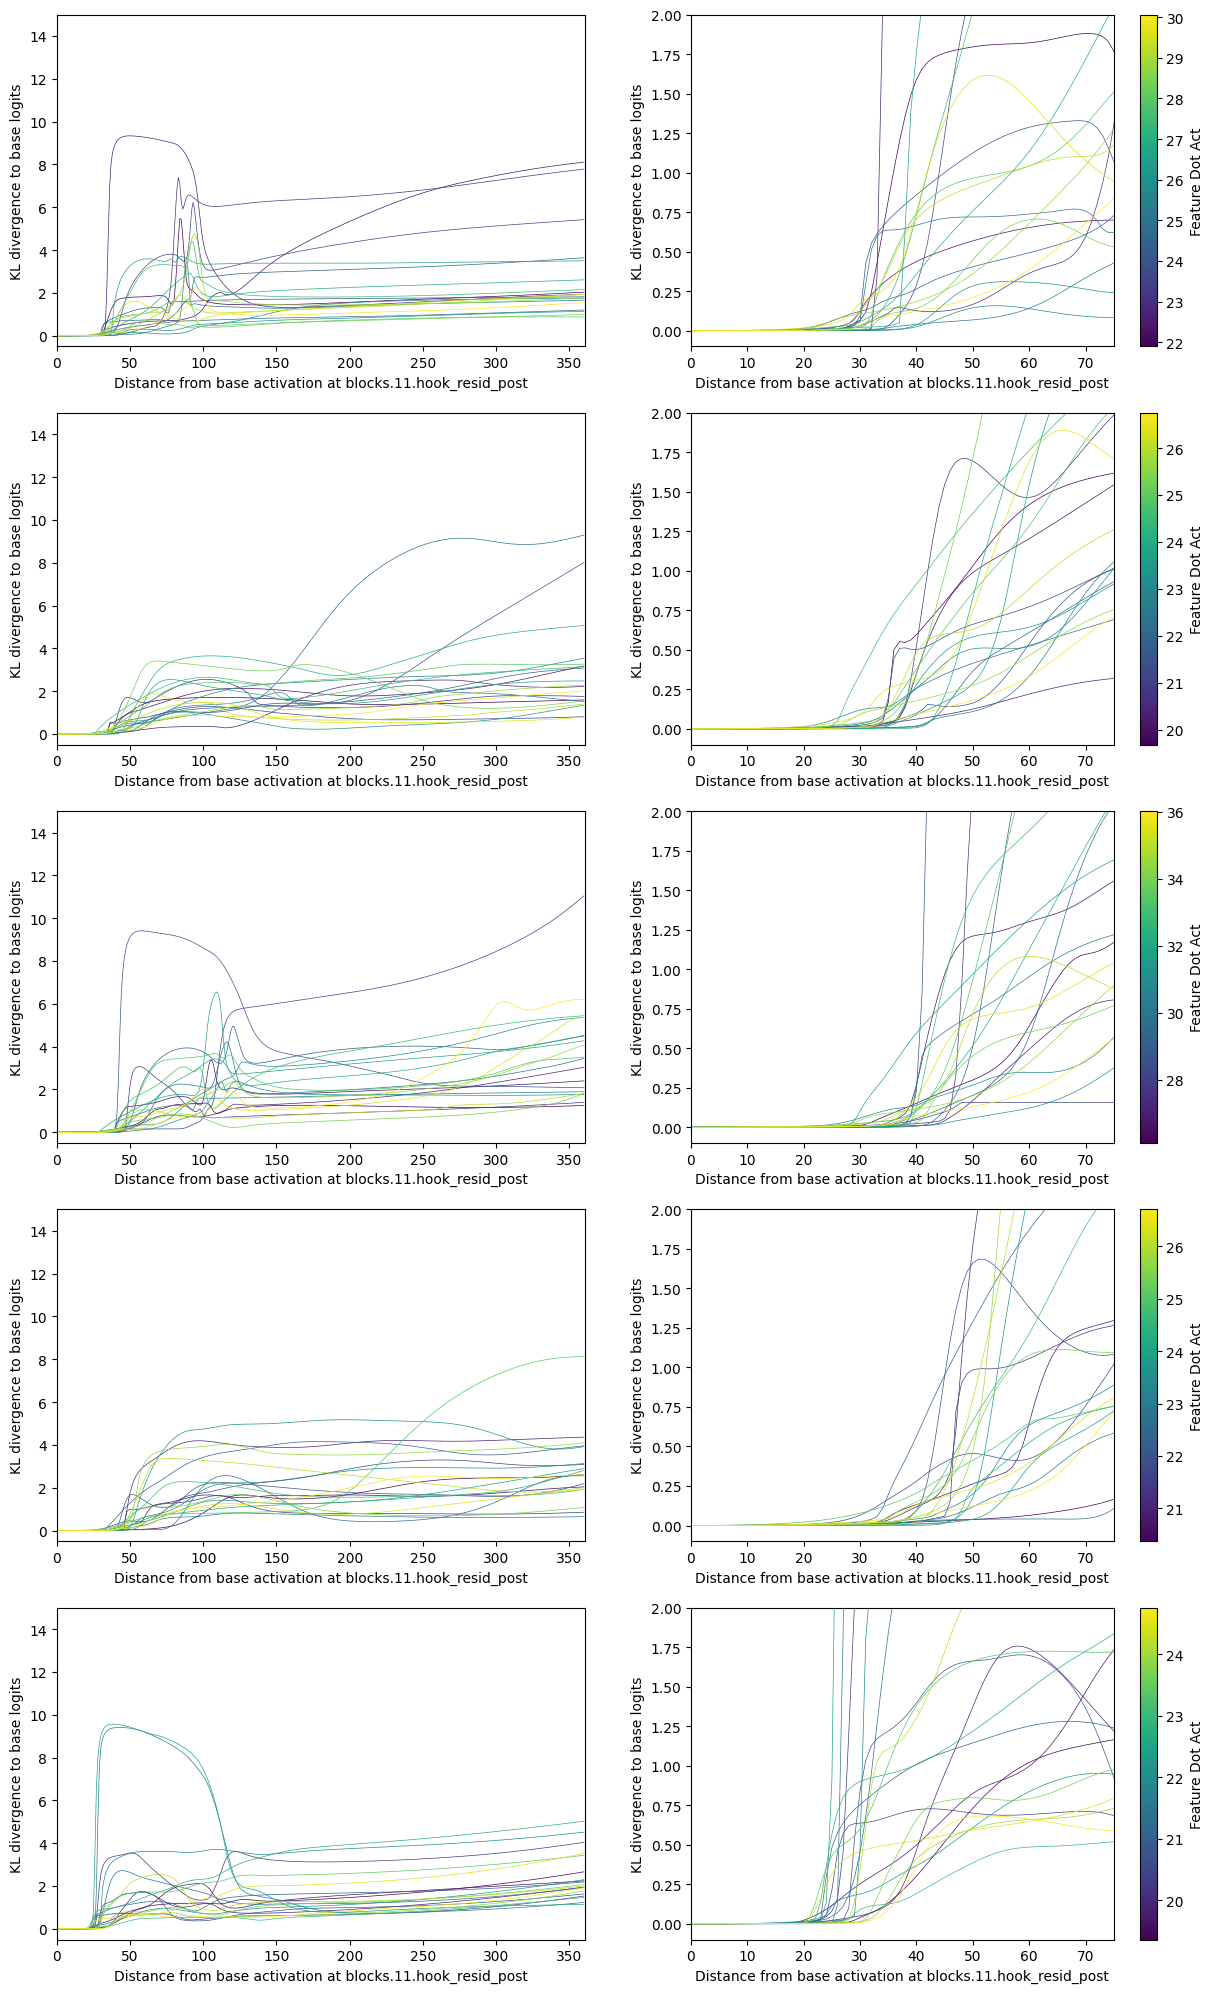

In [24]:
colors = plt.cm.viridis(np.linspace(0,1,20))
color_property = "Feature Dot Act"

fig, ax = plt.subplots(len(results.keys()), 2, figsize=(15,5*len(results.keys())))

for i, f_idx in enumerate(results.keys()):
    for j, data in enumerate([x for _, x in sorted(zip(chosen_features[f_idx][color_property], results[f_idx]['kl_div']))]):
        ax[i][0].plot(data, color=colors[j], linewidth=0.5)
        ax[i][1].plot(data, color=colors[j], linewidth=0.5)

        ax[i][0].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
        ax[i][0].set_ylabel("KL divergence to base logits")
        ax[i][0].set_xlim(0,361)
        ax[i][0].set_ylim(-0.5,15)

        ax[i][1].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
        ax[i][1].set_ylabel("KL divergence to base logits")
        ax[i][1].set_xlim(0,75)
        ax[i][1].set_ylim(-0.1,2)

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(chosen_features[f_idx][color_property]), vmax=max(chosen_features[f_idx][color_property])))
    cbar = fig.colorbar(sm, ax=ax[i][1])
    cbar.set_label(color_property)

fig.show()